## Эксперимент по вливанию коллекции в тематическую модель

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
%matplotlib inline
import os
import sys
import glob
import json
import shutil
import urllib
import pickle
import pymongo
import itertools
import collections
import numpy as np
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt

In [8]:
import artm
import hierarchy_utils

In [9]:
db = pymongo.MongoClient()["datasets"]

In [10]:
prefix_to_col_map = {"pn": "postnauka", "habr": "habrahabr", "elem": "elementy"}

def get_document(doc_id, with_markdown=False):
    fields = {"_id": 1, "title": 1, "modalities": 1}
    if with_markdown:
        fields["markdown"] = 1
    prefix, _ = doc_id.split("_", 1)
    col_name = prefix_to_col_map[prefix]
    return db[col_name].find_one({"_id": doc_id}, fields)

In [11]:
# Шаг 1 -- получение ранжированного списка документов для доливания

reduced_dataset = False
shuffled_dataset = False

docs_ids = list(map(lambda r: r["_id"], db["postnauka"].find({}, {"_id": 1})))

D_a = len(docs_ids)
print(D_a)

for csv_name, thresh in (("classifier_output_habr.csv", 0.95),
                         ("classifier_output_elem.csv", 0.55)):
    clf_output = pd.read_csv(csv_name)
    clf_output.columns = ["id", "proba"]
    clf_output = clf_output.set_index("id")["proba"]
    clf_output = clf_output[clf_output >= thresh]

    clf_output = clf_output.sort_values(ascending=False)

    if reduced_dataset:
        clf_output = clf_output[:5000]

    if shuffled_dataset:
        np.random.seed(42)
        clf_output = clf_output.sample(frac=1)

    docs_ids += list(clf_output.index)

    D_b = len(clf_output)
    print(D_b)

2976
1603
1655


**В `docs_ids` лежит ранжированный список документов, который потом разбивается на батчи (`batches`)**

In [12]:
docs_ids[:10]

['pn_2',
 'pn_3',
 'pn_4',
 'pn_5',
 'pn_6',
 'pn_7',
 'pn_8',
 'pn_9',
 'pn_13',
 'pn_14']

**Дальше разбиваем на батчи. Можно по закону сложного процента:**

In [11]:
# Шаг 2а -- разбиение списка на батчи для итеративного доливания

D_a0 = D_a // 10

# Будем пользоваться законом сложного процента: размер i-ого батча будет считаться как размер (i-1)-ого батча + p%.
# Тогда количество итераций n, необходимых для вливания коллекции размера D_b в коллекцию размера D_a, удовлетворяет:
# D_a * (1 + p)^n = D_a + D_b
# n = ln((D_a + D_b) / D_a) / ln(1 + p)

p = 0.1
batches = [docs_ids[:D_a], docs_ids[D_a:D_a + D_a0]]
batch_pos = D_a + D_a0

while batch_pos < len(docs_ids):
    new_batch_size = int((1 + p) * len(batches[-1]))
    batch = docs_ids[batch_pos:batch_pos + new_batch_size]
    batches.append(batch)
    batch_pos += new_batch_size

**А можно просто слить всё в один батч:**

In [12]:
# Шаг 2б -- склеивание всей коллекции в один батч

batches = [docs_ids]

**А можно порезать все батчи, начиная со второго, на куски по 1000 штук:**

In [13]:
batches = [docs_ids[:D_a], docs_ids[D_a:D_a + 1000], docs_ids[D_a + 1000:D_a + 2000],
           docs_ids[D_a + 2000:D_a + 3000], docs_ids[D_a + 3000:D_a + 4000], docs_ids[D_a + 4000:D_a + 5000]]

**А можно сначала Постнауку, а потом -- всё остальное:**

In [13]:
batches = [docs_ids[:D_a], docs_ids[D_a:]]

**А может быть, можно ещё как-то -- тут надо думать.**

Размеры батчей:

In [14]:
list(map(len, batches))

[2976, 3258]

Количество и суммарная длина батчей:

In [15]:
len(batches), sum(map(len, batches))

(2, 6234)

In [17]:
%%time

# Шаг 3 -- подгрузка словаря совстречаемостей (PPMI), подсчитываемого отдельного

artm_cooc_path = "merged_cooc_df_gt20.txt"

word_count = []
row, col, data = [], [], []
with open(artm_cooc_path) as cooc_f:
    for line in cooc_f:
        tokens = list(map(int, line.split()))
        if len(tokens) == 1:
            word_count.append(tokens[0])
        elif len(tokens) == 3:
            u, v, n_uv = tokens
            p_uv = n_uv / word_count[v]
            p_vu = n_uv / word_count[u]
            row.append(u); col.append(v); data.append(p_uv)
            row.append(v); col.append(u); data.append(p_vu)

w = h = len(word_count)
cooc_matrix = scipy.sparse.csr_matrix((data, (row, col)), shape=(w, h), dtype=np.float32)

del row, col, data

CPU times: user 1min 29s, sys: 2.01 s, total: 1min 31s
Wall time: 1min 30s


In [18]:
cooc_matrix

<231640x231640 sparse matrix of type '<class 'numpy.float32'>'
	with 38931218 stored elements in Compressed Sparse Row format>

In [16]:
# Параметры ARTM модели

# Общий random seed
artm_seed = 37

# Названия тем
# TODO: скрытые константы
norm_topic_names = ["topic_%d" % i for i in range(0, 19)]
background_names = ["background_%d" % i for i in range(0, 1)]
topic_names0 = norm_topic_names + background_names

# Регуляризаторы
regularizers_list0 = []
regularizers_list0.append(artm.DecorrelatorPhiRegularizer(name="DecorrPhiReg",
                                                          topic_names=norm_topic_names,
                                                          tau=100000))
regularizers_list0.append(artm.SmoothSparseThetaRegularizer(name="SPPhiTagRegBackground",
                                                           topic_names=background_names,
                                                           tau=100))

# Веса всех модальностей
class_ids0 = {"text": 1.0, "flat_tag": 300.0, "text_habr": 1.0, "flat_tag_habr": 1.0}
class_ids1 = {"text": 1.0, "flat_tag": 1.0,   "text_habr": 1.0, "flat_tag_habr": 1.0}

In [17]:
# Параметры алгоритма CollectionMerge

modalities_to_use = ["flat_tag", "text"]
vw_path = "batch_vw.txt"
artm_ppmi_path = "merged_ppmi.txt"
artm_vocab_path = "merged_vocab.txt"
artm_batch_path = "merged_batches/"
tmp_artm_batch_path = "./"

In [18]:
def build_level1(topics_cnt, level0, prev_phi, dictionary, batch_vectorizer, scores_list):
    # Названия тем
    topic_names1 = ["topic_%d" % i for i in range(topics_cnt)]

    # Список регуляризаторов
    regularizers_list1 = []
    regularizers_list1.append(artm.DecorrelatorPhiRegularizer(name="DecorrPhiReg1",
                              topic_names=topic_names1, tau=50000))

    # Создадим ARTM модель (второй уровень)
    level1 = hierarchy_utils.ARTM_Level(level0, phi_batch_weight=10.0**3, 
                                        topic_names=topic_names1,
                                        class_ids=class_ids1,
                                        regularizers=regularizers_list1,
                                        scores=scores_list,
                                        num_document_passes=1,
                                        cache_theta=True, theta_columns_naming="title",
                                        seed=artm_seed)
    level1.initialize(dictionary=dictionary)

    # Инициализиуем матрицу Фи значениями с предыдущей итерации
    if prev_phi is not None:
        _, phi_ref = level1.master.attach_model(level1.model_pwt)
        print(prev_phi.shape, phi_ref.shape)
        for i, j in itertools.product(*map(range, prev_phi.shape)):
            phi_ref[i, j] = prev_phi[i, j]

    # Обучим модель второго уровня
    # TODO: подобрать количество итераций
    level1.fit_offline(batch_vectorizer, num_collection_passes=5)

    # Итеративное разреживание детей тем 0 уровня
    threshold = 0.05
    psi1 = level1.get_psi()
    for tau in np.arange(0.1, 0.6, 0.1):
        child_topics = []
        for t in range(len(level0.topic_names)):
            child_topics.append([])
            for s, topic_name1 in enumerate(level1.topic_names):
                if psi1.values[s, t] > threshold:
                    child_topics[t].append(topic_name1)
        # Разреживание детей каждой темы 0 уровня между собой
        for i in range(len(level0.topic_names)):
            topics_list = child_topics[i]
            level1.regularizers.add(artm.SmoothSparseThetaRegularizer(
                                    name="SPThetaReg_%d" % i,
                                    topic_names=topics_list, 
                                    tau=-tau * len(topics_list) ** 3), overwrite=True)
        # Дообучим модель второго уровня
        # TODO: подобрать количество итераций
        level1.fit_offline(batch_vectorizer, num_collection_passes=1)

    return level1

**Собственно, алгоритм итеративного обучения CollectionMerge:**

In [19]:
%%time

max_batch_size = max(map(len, batches))

vocab_map = {}
prev_phi0 = None
prev_phi1 = None

docs_length = 0
word_count = {}
pair_count = {}

all_chars = list(map(chr, range(ord('a'), ord('z') + 1)))
artm_batch_names_iter = itertools.product(*([all_chars] * 6))
batch_names = ["".join(next(artm_batch_names_iter)) for i in range(len(batches))]

t2 = 60

psis = []
levels = []

# Удалим содержимое директории с ARTM батчами
for fname in glob.glob(artm_batch_path + "/*"):
    os.remove(fname)

# Создадим файлы с ARTM vocabulary
open(artm_vocab_path, "w").close()

for iter_no, (batch_name, batch) in enumerate(zip(batch_names, batches)):
    prev_vocab_size = len(vocab_map)
    batch_vocab = []
    batch_n_d = collections.defaultdict(int)
    batch_n_wd = collections.defaultdict(int)

    # Запишем документы и словарь из батча в файлы
    with open(vw_path, "w") as vw_f, open(artm_vocab_path, "a") as vocab_f:
        for i_d, doc in enumerate(map(get_document, batch)):
            doc_id = doc["_id"]
            modalities_str = []
            for mod_name in modalities_to_use:
                mod = doc["modalities"].get(mod_name, [])
                mods = []
                for token in mod:
                    token = token.replace(" ", "_")
                    vocab_entry = (token, mod_name)
                    if iter_no == 0 or (iter_no > 0 and vocab_entry in vocab_map):
                        mods.append(token)
                    if vocab_entry not in vocab_map and iter_no == 0:
                        vocab_map[vocab_entry] = len(vocab_map)
                        batch_vocab.append(vocab_entry)
                    #i_w = vocab_map[vocab_entry]
                    #batch_n_wd[i_w, i_d] += 1
                modalities_str.append("|%s %s" % (mod_name, " ".join(mods)))
                #for token in set(mod):
                #    token = token.replace(" ", "_")
                #    i_w = vocab_map[token, mod_name]
                #    batch_n_d[i_w] += 1
            vw_f.write("%s %s\n" % (doc_id, " ".join(modalities_str)))
        for vocab_entry in batch_vocab:
            vocab_f.write("%s %s\n" % vocab_entry)
    
    print("New vocab size:", len(batch_vocab))
    break
    
    # Создадим матрицу P(w_old|d_new)
    """
    row, col, data = [], [], []
    for (i_w, i_d), n_wd in batch_n_wd.items():
        if i_w < prev_vocab_size:
            p_wd = n_wd / batch_n_d[i_w]
            row.append(i_w)
            col.append(i_d)
            data.append(p_wd)
    w = prev_vocab_size
    h = len(batch)
    batch_p_wd_old = scipy.sparse.csr_matrix((data, (row, col)), shape=(w, h), dtype=np.float32)
    
    # Создадим матрицу P(w_new|d_new)
    row, col, data = [], [], []
    for (i_w, i_d), n_wd in batch_n_wd.items():
        if i_w >= prev_vocab_size:
            p_wd = n_wd / batch_n_d[i_w]
            row.append(i_w - prev_vocab_size)
            col.append(i_d)
            data.append(p_wd)
    w = len(batch_vocab)
    h = len(batch)
    batch_p_wd_new = scipy.sparse.csr_matrix((data, (row, col)), shape=(w, h), dtype=np.float32)
    """

    # Создадим ARTM батч по нашему батчу
    tmp_batch_vectorizer = artm.BatchVectorizer(data_format="vowpal_wabbit", data_path=vw_path,
                                                batch_size=max_batch_size, target_folder=tmp_artm_batch_path,
                                                gather_dictionary=False)
    # Хак: переименуем ARTM батч во временное имя,
    # чтобы не мешать созданию других ARTM батчей
    os.rename("%s/aaaaaa.batch" % tmp_artm_batch_path,
              "%s/%s.batch"     % (artm_batch_path, batch_name))

    # Создадим ARTM модель (первый уровень)
    dictionary = artm.Dictionary("dictionary")
    dictionary.gather(artm_batch_path, vocab_file_path=artm_vocab_path,
                      cooc_file_path=artm_ppmi_path, symmetric_cooc_values=True)

    # Метрики качества
    scores_list = []
    scores_list.append(artm.PerplexityScore(name="PerplexityScore", class_ids=["text"]))
    scores_list.append(artm.TopTokensScore(name="Top50Tokens", class_id="text", num_tokens=50,
                                           dictionary=dictionary))
    scores_list.append(artm.TopTokensScore(name="Top10Tags", class_id="flat_tag", num_tokens=10,
                                           dictionary=dictionary))

    level0 = artm.ARTM(topic_names=topic_names0, class_ids=class_ids0,
                       regularizers=regularizers_list0, scores=scores_list,
                       cache_theta=True, theta_columns_naming="title",
                       seed=artm_seed)
    level0.initialize(dictionary=dictionary)
    
    # Загрузим созданные на данный момент ARTM батчи
    #data_paths = list(map(lambda i: "%s/%d" % (artm_batch_path, i), range(iter_no + 1)))
    #data_weights = list((1 - p) ** np.arange(iter_no + 1))
    batch_vectorizer = artm.BatchVectorizer(data_format="batches", data_path=artm_batch_path,
                                            gather_dictionary=False)
    
    # Инициализиуем матрицу Фи значениями с предыдущей итерации
    if prev_phi0 is not None:
        # Инициализируем верхнюю часть Фи матрицей Фи с предыдущей итерации
        _, phi_ref = level0.master.attach_model(level0.model_pwt)
        print(prev_phi0.shape, phi_ref.shape)
        for i, j in itertools.product(*map(range, prev_phi0.shape)):
            phi_ref[i, j] = prev_phi0[i, j]

        # Инициализируем нижнюю часть Фи различными оценками
        ff_score = 0.0
        if False:
            start_token_id = prev_phi0.shape[0]
            end_token_id = phi_ref.shape[0]

            for token_id in range(start_token_id, end_token_id):
                token_cooc_row = cooc_matrix[token_id]
                data, col = token_cooc_row.data, token_cooc_row.nonzero()[1]

                if len(data) > 0:
                    length = np.argmin(col < start_token_id)

                    pvt = prev_phi0[col[:length]]
                    pwv = data[:length]
                    pwt = pwv.dot(pvt)

                    # Посчитаем метрику качества инициализции
                    pvd_new = batch_p_wd_new[token_id - start_token_id]
                    pvd_old = batch_p_wd_old[col[:length]]
                    cf_score = pvd_new.toarray() - pvd_old.T.dot(pwv)
                    ff_score += np.linalg.norm(cf_score)

                    for j in range(prev_phi0.shape[1]):
                        phi_ref[token_id, j] = pwt[j]
                else:
                    pvd_new = batch_p_wd_new[token_id - start_token_id]
                    cf_score = pvd_new.toarray()
                    ff_score += np.linalg.norm(cf_score)
        #print("Level 0 FF score: %.6f" % ff_score)

    # Обучим модель первого уровня
    # TODO: подобрать количество итераций
    level0.fit_offline(batch_vectorizer, num_collection_passes=10)
    print("Level 0 perplexity: %.6f" % level0.score_tracker["PerplexityScore"].last_value)
    print("Level 0 coherence: %.6f" % level0.score_tracker["Top50Tokens"].last_average_coherence)
    print("Iteration %d, level 0 built" % iter_no)

    # Построим модель второго уровня
    #max_coherence = 0
    #max_t2 = cur_t2
    #for t2 in range(cur_t2 - 4, cur_t2 + 12, 2):
    level1 = build_level1(t2, level0, prev_phi1, dictionary, batch_vectorizer, scores_list)
    print("Level 1 perplexity: %.6f" % level1.score_tracker["PerplexityScore"].last_value)
    print("Level 1 coherence: %.6f" % level1.score_tracker["Top50Tokens"].last_average_coherence)
    print("Iteration %d, level 1 built" % iter_no)
    #if t2 == 19 * 3:
    #    t2 += 10

    # Сохраним матрицы Фи первого и второго уровня с текущей итерации
    prev_phi0 = level0.get_phi().values
    prev_phi1 = level1.get_phi().values

    # Сохраним уровни для истории
    levels.append((level0, level1))
    #hier = hierarchy_utils.hARTM(class_ids=class_ids0, regularizers=regularizers_list0, scores=scores_list,
    #                         cache_theta=True, seed=artm_seed)
    #hier._levels.append(level0)
    #hier._levels.append(level1)
    #hiers.append(hier)

New vocab size: 44995
CPU times: user 3.29 s, sys: 140 ms, total: 3.43 s
Wall time: 3.73 s


**Получившиеся темы первого уровня:**

In [23]:
sorted([(k, " ".join(v[:3])) for k, v in levels[-1][0].score_tracker["Top10Tags"].last_tokens.items()])

[('background_0', 'биология технологии микробиология'),
 ('topic_0', 'философия история_россии история'),
 ('topic_1', 'эволюция антропология биология'),
 ('topic_10', 'медицина биология генетика'),
 ('topic_11', 'физика физика_элементарных_частиц квантовая_физика'),
 ('topic_12', 'история_науки наука образование'),
 ('topic_13', 'химия люди_науки космология'),
 ('topic_14', 'общество образование наука_и_общество'),
 ('topic_15', 'математика информационные_технологии информатика'),
 ('topic_16', 'средневековье история мифология'),
 ('topic_17', 'экология зоология биология'),
 ('topic_18', 'мозг нейробиология искусственный_интеллект'),
 ('topic_2', 'экономика география стартап'),
 ('topic_3', 'культура литература культурология'),
 ('topic_4', 'история политика ссср'),
 ('topic_5', 'астрономия астрофизика космос'),
 ('topic_6', 'лингвистика язык право'),
 ('topic_7', 'социология социология_повседневности дюркгейм_эмиль'),
 ('topic_8', 'россия государство сша'),
 ('topic_9', 'психология и

**Получившиеся темы второго уровня:**

In [25]:
sorted([(k, " ".join(v[:3])) for k, v in levels[-1][1].score_tracker["Top10Tags"].last_tokens.items()])

[('topic_0', 'политическая_философия история_философии история_россии'),
 ('topic_1', 'генетика ген биология'),
 ('topic_10', 'генетика геном белки'),
 ('topic_11', 'физика физика_элементарных_частиц квантовая_физика'),
 ('topic_12', 'история_науки наука гендер'),
 ('topic_13', 'вселенная гравитационные_волны рентгеновское_излучение'),
 ('topic_14', 'антропология человек происхождение_человека'),
 ('topic_15', 'технологии юзабилити работа'),
 ('topic_16', 'история религиоведение фольклор'),
 ('topic_17', 'филология культурология массовая_культура'),
 ('topic_18', 'поведение_животных нобелевская_премия зоопсихология'),
 ('topic_19', 'микробиология биотехнологии микробы'),
 ('topic_2', 'стартапы информационная_безопасность авторское_право'),
 ('topic_20', 'человек биология антропогенез'),
 ('topic_21', 'история_россии история кавказ'),
 ('topic_22', 'биология молекулярная_биология наука_в_россии'),
 ('topic_23', 'искусственный_интеллект нейробиология эмоции'),
 ('topic_24', 'история вост

In [20]:
#for level_id, level in enumerate(levels):
#    level.save("article_models/new_random_small_batches_%d.model" % level_id)

---

In [19]:
#hiers[-1].save("hartm")
#
#extra_info = {
#    "class_ids": class_ids0,
#    "theta": hiers[-1].get_theta(),
#}
#
#pickle.dump(extra_info, open("hartm/extra_info.dump", "wb"))

---

**Какие-то статистики (в том числе и из старой Машиной тетрадки), которые можно позапускать без гарантии успеха:**

### Proposed algorithm

### Baseline

In [41]:
phi0 = levels[0].get_phi()

In [27]:
np.mean((phi0 > 0).sum(axis=1))

9.509999226365466

In [26]:
np.median((phi0 > 0).sum(axis=1))

8.0

In [28]:
sorted([(k, " ".join(v[:3])) for k, v in levels[0].score_tracker["Top50Tokens"].last_tokens.items()])

[('background_0', 'проект работать компания'),
 ('topic_0', 'россия русский политический'),
 ('topic_1', 'клетка организм ген'),
 ('topic_10', 'дизайн экран страница'),
 ('topic_11', 'частица двигатель полет'),
 ('topic_12', 'файл код объект'),
 ('topic_13', 'материал энергия температура'),
 ('topic_14', 'компания студент проект'),
 ('topic_15', 'алгоритм значение число'),
 ('topic_16', 'посылка биткоин днк'),
 ('topic_17', 'сервер данные пользователь'),
 ('topic_18', 'мозг память технология'),
 ('topic_2', 'устройство камера датчик'),
 ('topic_3', 'напряжение фильм сигнал'),
 ('topic_4', 'нейрон сеть интеллект'),
 ('topic_5', 'звезда планета земля'),
 ('topic_6', 'право закон договор'),
 ('topic_7', 'код символ строка'),
 ('topic_8', 'компания рынок страна'),
 ('topic_9', 'задача ребенок часто')]

In [29]:
sorted([(k, " ".join(v[:3])) for k, v in levels[-1].score_tracker["Top10Tags"].last_tokens.items()])

[('background_0', 'интернет реклама авторское_право'),
 ('topic_0', 'история россия философия'),
 ('topic_1', 'биология медицина эволюция'),
 ('topic_10', 'дизайн архитектура творчество'),
 ('topic_11', 'физика китай физика_элементарных_частиц'),
 ('topic_12', 'социальные_сети наука электроника'),
 ('topic_13', 'химия биотехнологии нанотехнологии'),
 ('topic_14', 'образование сша марс'),
 ('topic_15', 'математика информационные_технологии статистика'),
 ('topic_16', 'днк геном средневековье'),
 ('topic_17', 'информационная_безопасность экология английский_язык'),
 ('topic_18', 'технологии мозг память'),
 ('topic_2', 'экономика география лазер'),
 ('topic_3', 'культура литература кино'),
 ('topic_4', 'искусственный_интеллект политика ссср'),
 ('topic_5', 'астрономия астрофизика космос'),
 ('topic_6', 'язык лингвистика право'),
 ('topic_7', 'социология клетка микробиология'),
 ('topic_8', 'общество государство социология'),
 ('topic_9', 'психология мышление когнитивная_психология')]

---

In [329]:
level0, level1 = levels[-1]
psi1 = level1.get_psi()

tokens0 = level0.score_tracker["Top10Tags"].last_tokens
tokens1 = level1.score_tracker["Top50Tokens"].last_tokens
threshold = 0.03

In [332]:
child_topics = []
output = ''
related = 0
for t, topic_name in enumerate(level0.topic_names):
    child_topics.append([])
    output += topic_name + ': '
    for word in tokens0[topic_name][:10]:    
        output += word + ' '
    print("\x1b[1;31m PARENT: ", output, '\x1b[0m')
    output=''
    for s, topic_name1 in enumerate(level1.topic_names):
        if (psi1.values[s, t] > threshold):
            child_topics[t].append(topic_name1)
            related += 1
            output += "    "+ topic_name1 + ': '
            for word in tokens1[topic_name1][:10]:    
                output += word + ' '
            print (output)
            output =''
print("\n edges: ", related)

related_topics = 0
for row in (psi1.values>threshold):
    if (sum(row) != 0):
        related_topics += 1

print(related_topics,"topics have parents")    

 PARENT:  topic_0: россия философия история_россии история политическая_философия история_философии античность археология древняя_греция аристотель  
    topic_0: россия археология античность русь платон этика мораль аристотель тирания смерть 
    topic_5: россия философия аристотель платон власть этнография религия археология землетрясение тирания 
    topic_50: философия россия рим античность аристотель археология сократ этика платон смерть 
    topic_54: философия россия античность аристотель сократ русь медиевистика этнография ксенофонт геология 
    topic_66: философия россия платон античность археология медиевистика смерть геология аристотель сейсмология 
 PARENT:  topic_1: эволюция биология антропология человек палеонтология антропогенез физиология иммунитет происхождение_человека дарвин_чарльз  
    topic_14: эволюция палеонтология физиология иммунитет неврология геология стресс иммунология чтение этнография 
    topic_30: общество государство европа япония россия этнос рынок г

In [335]:
child_topics = []
output = ''
related = 0
for t, topic_name in enumerate(level0.topic_names):
    child_topics.append([])
    output += topic_name + ': '
    for word in tokens0[topic_name][:10]:    
        output += word + ' '
    print("\x1b[1;31m PARENT: ", output, '\x1b[0m')
    output=''
    for s, topic_name1 in enumerate(level1.topic_names):
        if (psi1.values[s, t] > threshold):
            child_topics[t].append(topic_name1)
            related += 1
            output += "    "+ topic_name1 + ': '
            for word in tokens1[topic_name1][:10]:    
                output += word + ' '
            print (output)
            output =''
print("\n edges: ", related)

related_topics = 0
for row in (psi1.values>threshold):
    if (sum(row) != 0):
        related_topics += 1

print(related_topics,"topics have parents")    

 PARENT:  topic_0: россия философия история_россии история политическая_философия история_философии античность археология древняя_греция аристотель  
    topic_0: россия археология античность русь платон этика мораль аристотель тирания смерть 
    topic_5: россия философия аристотель платон власть этнография религия археология землетрясение тирания 
    topic_50: философия россия рим античность аристотель археология сократ этика платон смерть 
    topic_54: философия россия античность аристотель сократ русь медиевистика этнография ксенофонт геология 
    topic_66: философия россия платон античность археология медиевистика смерть геология аристотель сейсмология 
 PARENT:  topic_1: эволюция биология антропология человек палеонтология антропогенез физиология иммунитет происхождение_человека дарвин_чарльз  
    topic_14: эволюция палеонтология физиология иммунитет неврология геология стресс иммунология чтение этнография 
    topic_30: общество государство европа япония россия этнос рынок г

### Модель Постнауки

In [19]:
level0.score_tracker["PerplexityScore"].value[-5:]

[4963.209150427969,
 4808.3937992762585,
 4711.4371450207145,
 4646.651873869753,
 4600.3827374075645]

In [19]:
level1.score_tracker["PerplexityScore"].value[-5:]

[3685.78738631352,
 3051.851748745416,
 2521.292074881631,
 2167.2430489298386,
 1962.906177565747]

In [20]:
print("\n".join([k + ": " + " ".join(v) for k, v in level0.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_16: культура традиция христианский миф греческий текст христианство фольклор восток бог
topic_17: литература роман старение литературный текст русский писатель поэт мутация произведение
topic_12: социальный социология философия фильм отношение политический общество смысл пространство объект
topic_8: ребенок общество женщина политический мужчина группа социальный низкий вес семья
topic_4: клетка заболевание болезнь пациент препарат лечение врач вирус медицина организм
topic_6: страна экономический экономика государство политика политический решение рынок государственный банк
topic_10: материал свет квантовый магнитный технология использовать структура температура атом поле
topic_2: русский словарь речь текст языковой лингвист глагол значение ребенок предложение
topic_15: мозг нейрон память интеллект информация клетка нервный робот нейронный активность
topic_13: право россия власть русский церковь революция король закон российский политический
topic_7: галактика вселенная звезда ды

In [21]:
print("\n".join([k + ": " + " ".join(v) for k, v in level1.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_16: клетка эволюция использовать состояние информация позволять организм область применение уровень
topic_32: днк ссср математика клетка информатика рнк интернет эволюция ученый заниматься
topic_17: литература этнография старение поэзия мутация белок праздник смерть обряд апоптоз
topic_20: микробиология экология эволюция палеонтология земля антропология геология неандерталец homo ирландия
topic_55: физика химия механика частица кристалл электрон атом суперсимметрия молекула симметрия
topic_7: модель структура молекула физика использовать связь область пространство точка свойство
topic_50: физика химия частица коллайдер атом кварк энергия механика кристаллография протон
topic_38: днк решение сторона ссср отношение страна развитие социальный класс математика
topic_61: интернет пример коммуникация значение днк русский число место давать математика
topic_41: астрофизика галактика материя космология космос солнце телескоп марс земля дыра
topic_21: интернет часть идти область создавать

In [22]:
level0.score_tracker["Top10Tokens"].last_average_coherence

0.9023335576057434

In [23]:
level1.score_tracker["Top10Tokens"].last_average_coherence

0.9078970551490784

### Предлагаемый алгоритм

In [19]:
level0.score_tracker["PerplexityScore"].value[-5:]

[4836.956410790245,
 4782.862418550982,
 4740.216295517623,
 4706.340675376192,
 4678.839394335528]

In [20]:
level1.score_tracker["PerplexityScore"].value[-5:]

[6467.428530078471,
 5829.809875738739,
 4962.698695392981,
 4185.622408561892,
 3668.0637924598036]

In [21]:
print("\n".join([k + ": " + " ".join(v) for k, v in level0.score_tracker["Top10Tokens"].last_tokens.items()]))

background_0: работать проект использовать задача информация давать возможность хороший статья решение
topic_5: звезда планета земля космический солнце орбита солнечный спутник полет масса
topic_15: память мозг нейрон робот модель функция процессор контроллер интеллект значение
topic_1: частица число квантовый поле энергия точка физика свойство атом взаимодействие
topic_10: устройство датчик камера материал питание сигнал напряжение технология корпус экран
topic_6: компания деньги бизнес рынок цена страна клиент услуга банк товар
topic_18: образование научный университет школа студент культура ученый знание курс заниматься
topic_7: вселенная галактика изображение черный дыра объект звезда излучение материя темный
topic_2: русский текст словарь речь символ буква значение английский звук языковой
topic_12: социальный политический фильм философия отношение пространство общество социология понятие смысл
topic_17: игра игрок персонаж герой играть литература роман бэббидж писатель рука
topic

In [22]:
print("\n".join([k + ": " + " ".join(v) for k, v in level1.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_34: культура образование школа университет статистика студент власть знание егэ ученый
topic_11: государство экономика россия компания бизнес интернет проект ситуация деньги идея
topic_15: мозг память интеллект нейрон робототехника робот сознание нейропсихология синапс кибернетика
topic_72: космос гравитация земля астрофизика психология космонавтика солнце марс звезда луна
topic_35: интернет вид днк место видеть находить ссср данный появляться работать
topic_36: экономика государство политика рынок политология бизнес деньги компания страна капитал
topic_57: приложение сервер город криптография файл архитектура география пользователь запрос версия
topic_9: социология идентичность философия миграция пространство объект кино личность город социальный
topic_17: литература игра старение мутация этнография поэзия игрок спорт белок логика
topic_25: инфляция интернет проект информация основной возможность использовать давать продукт днк
topic_59: психология мышление этология мотивация пр

In [23]:
level0.score_tracker["Top10Tokens"].last_average_coherence

0.9543054699897766

In [24]:
level1.score_tracker["Top10Tokens"].last_average_coherence

0.8893764615058899

In [25]:
%%time

docs_lengths = {}

for doc in map(get_document, docs_ids):
    docs_lengths[doc["_id"]] = len(doc["modalities"]["text"])

CPU times: user 3.44 s, sys: 323 ms, total: 3.77 s
Wall time: 4.39 s


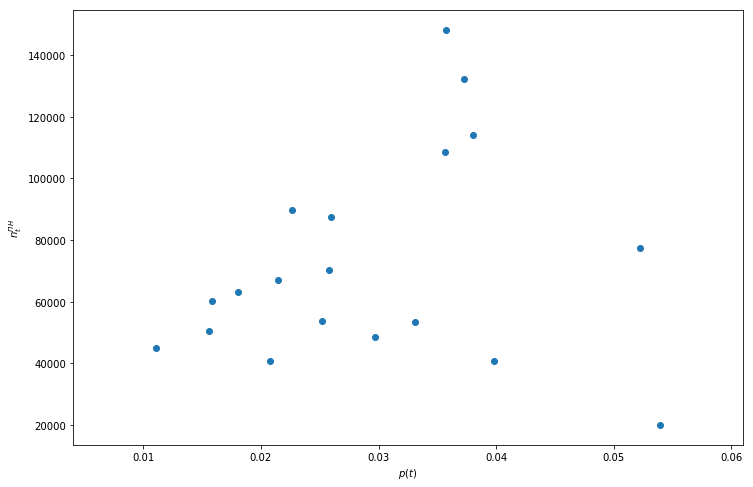

In [26]:
theta0 = level0.get_theta()

docs_lengths_series = pd.Series(docs_lengths)
pn_docs_ids = list(filter(lambda doc_id: doc_id.startswith("pn_"), docs_ids))
n_pn_topics = theta0[pn_docs_ids].dot(docs_lengths_series.loc[pn_docs_ids])
n_topics = theta0.dot(docs_lengths_series)
n_topics /= n_topics.sum()

plt.figure(figsize=(12, 8))
plt.scatter(n_topics[:-1], n_pn_topics[:-1])
plt.xlabel("$p(t)$")
plt.ylabel("$n_t^{ПН}$")
#plt.xlim([0, 0.02])
#plt.ylim([0, 25000])
plt.show()

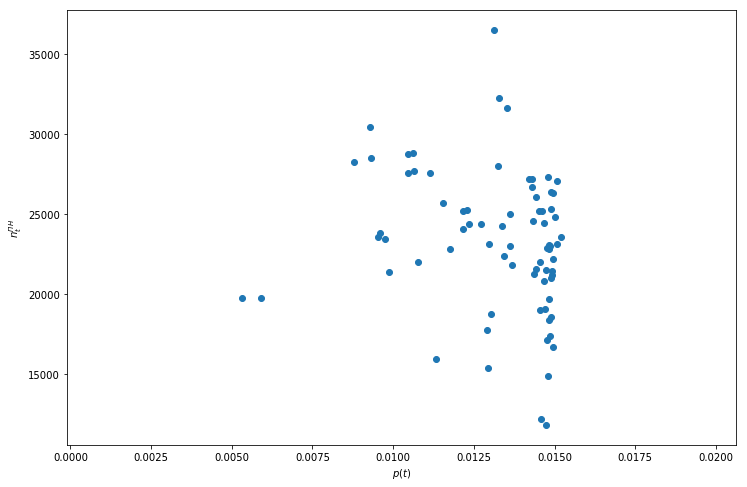

In [27]:
theta1 = level1.get_theta()

docs_lengths_series = pd.Series(docs_lengths)
pn_docs_ids = list(filter(lambda doc_id: doc_id.startswith("pn_"), docs_ids))
n_pn_topics = theta1[pn_docs_ids].dot(docs_lengths_series.loc[pn_docs_ids])
n_topics = theta1.dot(docs_lengths_series)
n_topics /= n_topics.sum()

plt.figure(figsize=(12, 8))
plt.scatter(n_topics, n_pn_topics)
plt.xlabel("$p(t)$")
plt.ylabel("$n_t^{ПН}$")
#plt.xlim([0, 0.02])
#plt.ylim([0, 25000])
plt.show()

### Базовый алгоритм

In [20]:
level0.score_tracker["PerplexityScore"].value[-5:]

[4963.209150427969,
 4808.3937992762585,
 4711.4371450207145,
 4646.651873869753,
 4600.3827374075645]

In [21]:
level1.score_tracker["PerplexityScore"].value[-5:]

[6624.167808136472,
 6134.6832006310515,
 5386.398648030325,
 4617.887055931921,
 4067.6294210970304]

In [22]:
print("\n".join([k + ": " + " ".join(v) for k, v in level0.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_10: волна частота свет материал квантовый магнитный ток сигнал двигатель использовать
topic_1: частица энергия физика квантовый взаимодействие поле кварк пространство свойство атом
topic_4: клетка заболевание болезнь пациент препарат лечение врач организм мозг медицина
topic_14: клетка ген организм белок растение вид вода днк молекула эволюция
topic_12: социальный политический общество фильм отношение философия социология пространство право смысл
topic_7: звезда галактика вселенная дыра черный объект масса излучение телескоп энергия
topic_6: игра страна рынок игрок экономический экономика деньги компания цена банк
topic_3: ребенок поведение психология задача внимание группа мышление эмоция способность животное
topic_8: файл код данные приложение использовать сервер пользователь версия запрос создавать
background_0: работать проект использовать задача хороший возможность информация давать пользователь решение
topic_9: город пространство городской ключ центр место здание данные акц

In [23]:
print("\n".join([k + ": " + " ".join(v) for k, v in level1.score_tracker["Top10Tokens"].last_tokens.items()]))

topic_10: работать математика использовать приложение проект сша пользователь создавать данные команда
topic_55: физика оптика сверхпроводимость свет лазер электрон gps микроскопия нанофотоника космонавтика
topic_67: использовать математика работать днк сторона заниматься статья пользователь хотеть находить
topic_59: психология мышление принятие внимание личность психика этология физиология поведение творчество
topic_22: математика работать элемент данные информация функция позволять число следующий простой
topic_72: психология мышление этология зоология физиология внимание стресс психотерапия психоанализ депрессия
topic_63: страна государство второй сторона конец россия европа ситуация идея развитие
topic_65: медицина климат клетка иммунология рим болезнь иммунитет античность кардиология неврология
topic_45: физика эволюция достаточно математика различный работать модель возникать второй находить
topic_36: работать устройство математика сторона данные информация решать решение результ

In [24]:
level0.score_tracker["Top10Tokens"].last_average_coherence

0.9703855514526367

In [25]:
level1.score_tracker["Top10Tokens"].last_average_coherence

0.879889726638794

In [25]:
%%time

docs_lengths = {}

for doc in map(get_document, docs_ids):
    docs_lengths[doc["_id"]] = len(doc["modalities"]["text"])

CPU times: user 3.11 s, sys: 279 ms, total: 3.39 s
Wall time: 3.86 s


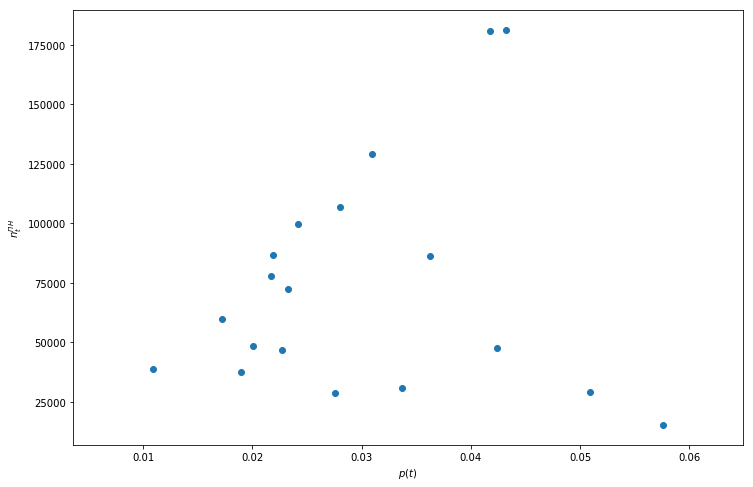

In [26]:
theta0 = level0.get_theta()

docs_lengths_series = pd.Series(docs_lengths)
pn_docs_ids = list(filter(lambda doc_id: doc_id.startswith("pn_"), docs_ids))
n_pn_topics = theta0[pn_docs_ids].dot(docs_lengths_series.loc[pn_docs_ids])
n_topics = theta0.dot(docs_lengths_series)
n_topics /= n_topics.sum()

plt.figure(figsize=(12, 8))
plt.scatter(n_topics[:-1], n_pn_topics[:-1])
plt.xlabel("$p(t)$")
plt.ylabel("$n_t^{ПН}$")
#plt.xlim([0, 0.02])
#plt.ylim([0, 25000])
plt.show()

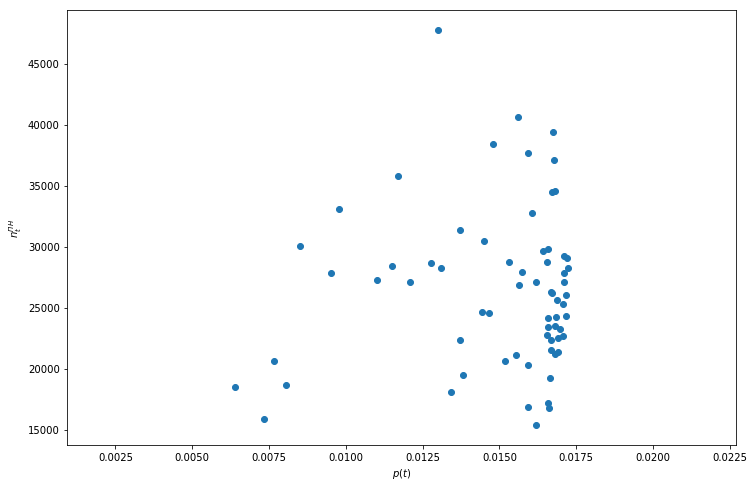

In [27]:
theta1 = level1.get_theta()

docs_lengths_series = pd.Series(docs_lengths)
pn_docs_ids = list(filter(lambda doc_id: doc_id.startswith("pn_"), docs_ids))
n_pn_topics = theta1[pn_docs_ids].dot(docs_lengths_series.loc[pn_docs_ids])
n_topics = theta1.dot(docs_lengths_series)
n_topics /= n_topics.sum()

plt.figure(figsize=(12, 8))
plt.scatter(n_topics, n_pn_topics)
plt.xlabel("$p(t)$")
plt.ylabel("$n_t^{ПН}$")
#plt.xlim([0, 0.02])
#plt.ylim([0, 25000])
plt.show()

**NB**: в конце провести эксперимент на перемешанном clf_output -- гипотеза о независимости качества от порядка вливания документов в ТМ.

---

---